# GASKAP - Absorption HI: LMC foreground

# Libraries

In [117]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import copy as cp
import healpy as hp

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord


from spectral_cube import SpectralCube

import matplotlib.pyplot as plt
import matplotlib        as mpl

import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from pathlib import Path

import seaborn as sns

In [ ]:
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.abspath(Path(script_dir) / os.pardir)
print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
gaussfit_dir = Path(parent_dir) / 'gaussfit'
print('gaussfit_dir: ', gaussfit_dir)
sys.path.append(parent_dir)
module_dir = Path(parent_dir) / 'gaussfit' / 'modules'
sys.path.append(module_dir)

print('script_dir: ', script_dir)
print('parent_dir: ', parent_dir)
print('gaussfit_dir: ', gaussfit_dir)

In [119]:
import libs.functions as fcn
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs
import libs.functions as fcn
import config.config as cf

In [120]:
# Set the font family for math symbols
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

# Display all colums
pd.set_option('display.max_columns', None)

# Paths

In [ ]:
base = Path.home()
askap = base / 'ANU' / 'ASKAP'
data_path = askap / 'data'
LMC_data_path = data_path / 'LMC'
LMC_GASKAP_data = LMC_data_path / 'lmc_gaskap'

cont_data_path = data_path / 'cont'
LMC_bridge_data = LMC_data_path / 'bridge'
GASS_em_spectra_path = LMC_data_path / 'neighbour_emission_spectra'
GASS_data_path = LMC_data_path / 'GASS'
HI_data_path = data_path / 'GASS'

SMC = askap / 'SMC'
SMC_data_path = data_path / 'SMC'
SMC_fg_data_path = SMC_data_path / 'fg'
SMC_fg_abs_data_path = SMC_fg_data_path / 'spectra'

hires_data = LMC_data_path / 'hires'
hires_results = hires_data / 'results'
hires_em_data = hires_data / 'cube'
hires_em_subcube_data = hires_em_data / 'subcubes'
hires_abs_data = hires_data / 'abs'
em_spectra_path = hires_data / 'neighbour_emission_spectra'
hires_em_profile_path = hires_data / 'em_profiles'
abs_dr3_data_path = hires_data / 'absdr3'

mwmc_data_path = data_path / 'mwmc'
mwmc_gaskap_path = mwmc_data_path / 'lmc_gaskap'

bridge_hires_abs_data = hires_abs_data / 'bridge'
LMC_hires_abs_data = hires_abs_data / 'lmc'

abs_path = mwmc_data_path / 'absorption'

BIGHICAT_data_path = data_path / 'BIGHICAT'


dust_data_path = data_path / 'dust'

# Absorption catalog DR3
print(abs_dr3_data_path)

# Read BIGHICAT

In [122]:
bighicat_file = os.path.join(BIGHICAT_data_path, 'all_unique_LOS_new.csv')
bighicat_df = pd.read_csv(bighicat_file)
bighicat_df = bighicat_df[np.isfinite(bighicat_df.lon) & np.isfinite(bighicat_df.lon)]
bighicat_nrows, bighicat_ncols = bighicat_df.shape
print(bighicat_nrows, bighicat_ncols)

373 30


In [123]:
bighicat_abs_df = bighicat_df[bighicat_df.ncomps > 0]
print(bighicat_abs_df.shape)
bighicat_abs_df

(309, 30)


,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,J17304,MACH,75.772200,33.067700,262.685109,49.106959,2.500000,0.120000,0.880000,0.300000,2.200000,206.266491,NaN,0.308840,0.005385,2.0,0.047189,0.001507,0.146285,0.004673,0.041254,0.127889,-17.716097,-0.306228,-0.234197,17.608982,0.372730,0.057,NaN,NaN
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,3.072800,308.619949,NaN,0.280609,0.008845,1.0,0.041178,0.001210,0.127653,0.003751,0.048668,0.150870,-6.611929,-0.689890,0.163849,18.828846,0.375549,0.055,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,2.079000,495.054726,NaN,0.101940,0.003759,1.0,0.028716,0.000767,0.089020,0.002379,0.024448,0.075789,-4.240314,-0.046202,-1.399806,16.961460,0.294231,0.074,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,2.900700,312.439362,NaN,0.170193,0.005946,2.0,0.044000,0.001390,0.136399,0.004308,0.049554,0.153618,-17.370651,-0.365892,-1.449508,18.306437,0.388935,0.059,NaN,NaN


In [124]:
bighicat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [125]:
bighicat_fcnm = bighicat_df['f_CNM_LOS']
bighicat_av = bighicat_df['AV_2013']

In [126]:
bighicat_gl = bighicat_df.lon.values
bighicat_gb = bighicat_df.lat.values

In [127]:
bighicat_ncomp = bighicat_df.ncomps.values

In [128]:
bighicat_non_abs_df = bighicat_df[bighicat_df.ncomps == 0]
bighicat_non_abs_df

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
27,3C245B,21-SPONGE,-126.877093,56.299360,160.684492,12.058768,2.198513,0.00,1.00,0.0000,2.198513,1082.171868,803.573257,0.023763,0.004366,0.0,0.029297,0.000570,0.090821,0.001768,0.031562,0.097842,11.849064,-0.726773,-0.340543,19.645941,0.261197,0.039,0.051164,0.029213
32,4C25.43,21-SPONGE,22.468218,80.988291,202.657038,25.153049,1.069102,0.00,1.00,0.0000,1.069102,3733.504250,NaN,0.003907,0.001377,0.0,0.012501,0.000726,0.038754,0.002250,0.016436,0.050951,10.991319,0.040548,-0.543543,18.101198,0.722656,0.069,-0.007498,0.019453
73,3C190.0,Millennium03,-152.400000,21.800000,120.341835,14.248369,2.820000,0.00,1.00,0.0000,2.820000,1144.671157,230.253648,0.231808,0.010320,0.0,0.035506,0.000481,0.110069,0.001491,0.039272,0.121742,26.237495,0.043048,0.125456,18.554049,0.166998,0.047,0.043490,0.026566
76,3C208.0,Millennium03,-146.300000,33.200000,133.338731,13.868658,2.990000,0.00,1.00,0.0000,2.990000,755.189603,20.606229,0.098838,0.002238,0.0,0.050187,0.001145,0.155581,0.003551,0.043913,0.136132,-2.143047,-0.803688,-0.242742,18.065907,0.273549,0.045,0.082940,0.042192
77,3C208.1,Millennium03,-146.400000,33.600000,133.682487,14.104676,2.760000,0.00,1.00,0.0000,2.760000,670.589538,18.379318,0.069161,0.002227,0.0,0.045763,0.000994,0.141866,0.003081,0.040235,0.124727,-14.962714,-0.384087,0.181879,18.029757,0.259302,0.053,0.099416,0.048666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,J16535,MACH,63.599700,38.859400,253.467225,39.759933,1.670000,0.00,1.00,0.0000,1.670000,NaN,NaN,0.014830,0.003823,0.0,0.018282,0.000348,0.056675,0.001078,0.025451,0.078899,-47.975391,0.088873,-1.476593,18.430862,0.233481,0.043,NaN,NaN
356,J16574,MACH,74.368300,38.477800,254.445018,48.142231,1.440000,0.01,0.99,0.0144,1.425600,3395.172797,NaN,0.020126,0.004525,0.0,0.020962,0.000382,0.064984,0.001186,0.027691,0.085842,0.163636,-1.077122,-1.168932,18.540604,0.225732,0.038,NaN,NaN
358,J16582,MACH,62.883200,37.928800,254.592088,39.106816,1.730000,0.00,1.00,0.0000,1.730000,1404.112422,NaN,0.028371,0.006243,0.0,0.020190,0.000540,0.062590,0.001675,0.022365,0.069331,45.782730,-0.000051,-0.141004,17.960539,0.319472,0.050,NaN,NaN
359,J17024,MACH,83.347100,37.316600,255.695643,55.277368,1.360000,0.02,0.98,0.0272,1.332800,5229.569563,NaN,0.034375,0.008572,0.0,0.021260,0.000468,0.065907,0.001452,0.025312,0.078468,5.028883,0.072909,0.020911,17.781618,0.258035,0.044,NaN,NaN


In [129]:
bighicat_nabs123_df = bighicat_df[(bighicat_df.ncomps > 0) & (bighicat_df.ncomps < 4)]
bighicat_nabs456_df = bighicat_df[(bighicat_df.ncomps > 3) & (bighicat_df.ncomps < 7)]
bighicat_nabs789_df = bighicat_df[(bighicat_df.ncomps > 6) & (bighicat_df.ncomps < 10)]
bighicat_nabs10_df = bighicat_df[bighicat_df.ncomps > 9]

In [ ]:
sponge_df = bighicat_abs_df[bighicat_df.survey == '21-SPONGE']
print(sponge_df.shape)
sponge_gl = sponge_df.lon.values
sponge_gb = sponge_df.lat.values
sponge_ncnm = sponge_df.ncomps.values
print(sponge_ncnm)
sponge_df

In [ ]:
ms_df = bighicat_df[bighicat_df.survey == 'Millennium03']
print(ms_df.shape)
ms_gl = ms_df.lon.values
ms_gb = ms_df.lat.values
ms_ncnm = ms_df.ncomps.values
print(ms_ncnm)
ms_df

In [ ]:
m_df = bighicat_df[bighicat_df.survey == 'MACH']
print(m_df.shape)
m_gl = m_df.lon.values
m_gb = m_df.lat.values
m_ncnm = m_df.ncomps.values
print(m_ncnm)
m_df

In [ ]:
z_df = bighicat_df[~bighicat_df.survey.isin(['MACH', '21-SPONGE', 'Millennium03'])]
print(z_df.shape)
z_gl = z_df.lon.values
z_gb = z_df.lat.values
z_ncnm = z_df.ncomps.values
print(z_ncnm)
z_df

### BIGHICAT high latitudes

In [134]:
blim = 20.

In [135]:
hghlat_df = bighicat_df[abs(bighicat_df.lat) > blim]
hghlat_df.head()

,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,e_int_Ts,tau_peak,tau_sensitivity,ncomps,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,1.658101,914.225482,97.669608,0.025003,0.000991,4.0,0.025335,0.000706,0.078539,0.002189,0.032554,0.100917,33.513996,-0.105451,-0.000096,18.925838,0.358167,0.025,0.065020,0.034327
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,2.995154,144.529741,2.137539,0.622906,0.001829,4.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.581377,0.263721
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,2.978961,145.948777,3.302026,0.641714,0.002671,2.0,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042,0.571241,0.258198
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,3.445285,706.217000,92.798770,0.038991,0.002728,3.0,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050,0.092098,0.045187
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,4.585191,694.696715,129.059712,0.057092,0.004103,3.0,0.054201,0.002183,0.168024,0.006768,0.075073,0.232728,0.130720,0.259304,0.039420,19.725590,0.554813,0.052,0.095320,0.047690


In [136]:
bighicat_df.survey.unique()

array(['21-SPONGE', 'Millennium03', 'Per14', 'GMRT04', 'TauGem19',
       'RiegelCrutcher18', 'MACH'], dtype=object)

In [137]:
hghlat_df.columns

Index(['source', 'survey', 'lon', 'lat', 'ra', 'dec', 'NHI_LOS', 'f_CNM_LOS',
       'f_WNM_LOS', 'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'e_int_Ts',
       'tau_peak', 'tau_sensitivity', 'ncomps', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14'],
      dtype='object')

In [138]:
bighicat_tau = hghlat_df.tau_peak.values
bighicat_sigtau = hghlat_df.tau_sensitivity.values

### BIGHICAT components

In [139]:
bighicat_cpn_file = os.path.join(BIGHICAT_data_path, 'all_unique_CNM_det_gaussian_components_new.csv')
bighicat_cpn_df = pd.read_csv(bighicat_cpn_file)
bighicat_cpn_nrows, bighicat_cpn_ncols = bighicat_cpn_df.shape
print(bighicat_cpn_nrows, bighicat_cpn_ncols)

1370 41


In [140]:
bighicat_cpn_df.columns

Index(['source', 'survey', 'lon', 'lat', 'tau', 'e_tau', 'fwhm_abs',
       'e_fwhm_abs', 'v_abs', 'e_v_abs', 'Tb', 'e_Tb', 'fwhm_em', 'e_fwhm_em',
       'v_em', 'e_v_em', 'NHI', 'e_NHI', 'Ts', 'e_Ts', 'ncomps', 'NHI_LOS',
       'f_CNM_LOS', 'f_CNM_LOS_KOK14', 'e_f_CNM_LOS_KOK14', 'f_WNM_LOS',
       'NHI_CNM_LOS', 'NHI_WNM_LOS', 'int_Ts', 'EBV_GNILC', 'e_EBV_GNILC',
       'AV_GNILC', 'e_AV_GNILC', 'EBV_2013', 'AV_2013', 'ICO10_1', 'ICO10_2',
       'ICO21', 'Td', 'e_Td', 'qPAH'],
      dtype='object')

In [141]:
hghlat_cpn_df = bighicat_cpn_df[(abs(bighicat_cpn_df.lat) > blim) & (bighicat_cpn_df.Ts.values < 500.)]
print(hghlat_cpn_df.shape)
hghlat_cpn_df.head()

(413, 41)


,source,survey,lon,lat,tau,e_tau,fwhm_abs,e_fwhm_abs,v_abs,e_v_abs,Tb,e_Tb,fwhm_em,e_fwhm_em,v_em,e_v_em,NHI,e_NHI,Ts,e_Ts,ncomps,NHI_LOS,f_CNM_LOS,f_CNM_LOS_KOK14,e_f_CNM_LOS_KOK14,f_WNM_LOS,NHI_CNM_LOS,NHI_WNM_LOS,int_Ts,EBV_GNILC,e_EBV_GNILC,AV_GNILC,e_AV_GNILC,EBV_2013,AV_2013,ICO10_1,ICO10_2,ICO21,Td,e_Td,qPAH
1,3C018A,21-SPONGE,118.623255,-52.731718,0.565354,0.006562,2.459576,0.019208588234467958,-9.141851,0.004865720945763916,6.904529,0.000000,2.976087,0.000000,-10.272452,0.000000,0.481065,0.040496,17.835869,1.480552,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
2,3C018A,21-SPONGE,118.623255,-52.731718,0.134434,0.002977,5.489022,0.16556715332829863,-6.190596,0.11759097439950161,25.182555,0.000000,6.006049,0.000000,-5.477219,0.000000,2.811484,0.130961,196.428242,5.449175,4.0,6.287702,0.523649,0.581377,0.263721,0.476351,3.292549,2.995154,144.529741,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
5,3C018B,21-SPONGE,118.616421,-52.718907,0.524365,0.003100,2.407914,0.014013971447450221,-8.976387,0.004214825863018799,6.564561,0.890459,2.677941,0.265945,-10.264445,0.346109,0.407920,0.060957,16.656050,2.485132,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
6,3C018B,21-SPONGE,118.616421,-52.718907,0.148800,0.002044,6.160155,0.05849457348843577,-6.774723,0.0487960503841556,22.468452,0.451441,6.993933,0.040578,-6.669918,0.021774,2.886451,0.099639,162.345752,4.904859,2.0,6.273332,0.525139,0.571241,0.258198,0.474861,3.294371,2.978961,145.948777,0.161014,0.010132,0.499145,0.031410,0.156406,0.484859,-34.840927,1.581829,-0.297675,18.217377,0.794297,0.042
7,3C041A,21-SPONGE,131.378783,-29.074651,0.032941,0.000624,8.871778,0.16242071465524413,-1.387832,0.08363020875003654,11.362727,0.000000,9.524291,0.000000,-1.384362,0.000000,1.994321,0.066650,351.823267,7.230769,3.0,5.463896,0.004445,0.092098,0.045187,0.630555,0.024289,3.445285,706.217000,0.054415,0.002150,0.168688,0.006666,0.075769,0.234883,5.707996,-0.018077,0.084511,19.713444,0.543411,0.050


In [142]:
bighicat_taucnm = hghlat_cpn_df.tau.values
bighicat_sigtaucnm = hghlat_cpn_df.e_tau.values

bighicat_tscnm = hghlat_cpn_df.Ts.values
bighicat_sigtscnm = hghlat_cpn_df.e_Ts.values

bighicat_cpn_glon = hghlat_cpn_df.lon.values
bighicat_cpn_glat = hghlat_cpn_df.lat.values

In [143]:
bighicat_cpn_glon[bighicat_cpn_glon < 0.] = bighicat_cpn_glon[bighicat_cpn_glon < 0.] + 360.

In [144]:
# Optical depth
total_ncnm = len(bighicat_taucnm)
print(f"Total CNM components: {total_ncnm}")

Total CNM components: 413


# HI4Pi

In [155]:
hi4pi_file    = HI_data_path / 'HI4PI_NH_GAL_1_1024.fits'
nhi_hi4pi_map = hp.read_map(hi4pi_file, field=0, hdu=True)
nside         = hp.get_nside(nhi_hi4pi_map)
res           = hp.nside2resol(nside, arcmin=False)
res_arcmin    = hp.nside2resol(nside, arcmin=True)
print(f"Resolution: {res} (radians), {res_arcmin} (arcmin)")

Resolution: 0.0009993424882289927 (radians), 3.435486411817406 (arcmin)


In [156]:
nhi_hi4pi_map.shape

(12582912,)

# Moment/Tbpeak Maps

In [169]:
# # Moment Maps
# moment0_file = GASS_data_path / 'moment0_LMC_fg.fits'
# m0, hdr = fits.getdata(moment0_file,header=True)
# print(m0.shape)

# # Parse the WCS keywords in the primary HDU
# hi_wcs = WCS(hdr)

# nhi_thin_map = m0*0.018224



# Tb,peak map
tbpeak_data_file = LMC_data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_45_arcs_FG_GASS_lb.fits'
print(tbpeak_data_file)
tbpeak_data, fg_hdr = fits.getdata(tbpeak_data_file, header=True)
print(tbpeak_data.shape)
fg_hdr

/Users/kiemhiep/ANU/ASKAP/data/LMC/Tbmax_Pilot_II_askap_parkes_PBC_45_arcs_FG_GASS_lb.fits


(5500, 7200)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7200                                                  
NAXIS2  =                 5500                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =               3540.0 / Pixel coordinate of reference point            
CRPIX2  =               1770.0 / Pixel coordinate of reference point            
CDELT1  =               -0.005 / [deg] Coordinate increment at reference point  
CDELT2  =                0.005 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'GLON-TAN'        

In [170]:
fg_wcs = WCS(fg_hdr)
fg_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 288.0000000000003  -42.99999999999974  
CRPIX : 3540.0  1770.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.005  0.005  
NAXIS : 7200  5500

In [171]:
# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = cf.SMC['circ']
LMC_xcirc, LMC_ycirc = cf.LMC['circ']

In [172]:
# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.88*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

In [173]:
c = SkyCoord(ch_xcirc, ch_ycirc, frame='galactic', unit='deg')
ch_xcirc_ra = c.fk5.ra.deg
ch_ycirc_dec = c.fk5.dec.deg
ch_xcirc_gl = c.l.deg
ch_ycirc_gb = c.b.deg

In [174]:
c = SkyCoord(cv_xcirc, cv_ycirc, frame='galactic', unit='deg')
cv_xcirc_ra = c.fk5.ra.deg
cv_ycirc_dec = c.fk5.dec.deg

cv_xcirc_gl = c.l.deg
cv_ycirc_gb = c.b.deg

In [175]:
tbpeak_data.shape

(5500, 7200)

# Read MW catalogue DR2

In [176]:
# All MC sightlines
# MC_fg_cat_file = gfit_path, "MC_fg_catalogue.csv"
MC_fg_cat_file = mwmc_data_path / 'gaskap_phase2_unique_spectra_v0.2c.csv'
df = pd.read_csv(MC_fg_cat_file)

nrows, ncols = df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
df.head(5)
# df.drop_duplicates(subset=['comp_name'], keep='first', inplace=True)
# df.shape

Number of rows: 2757, columns 30. 


,id,sbid,uniq_name,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope
0,7,33047,J053528-691612-33047,J053528-691612,SB33047_component_2a,83.866885,-69.270004,279.703720,-31.936985,A,720.179993,848.950012,0.003531,0.005301,0.420186,15.470555,1.025511,114.0,0.605325,263.765641,0.501989,0.012455,True,True,5.140,4.015,77.050003,3.360408e+21,False,-0.003089
1,8,33047,J060005-703833-33047,J060005-703833,SB33047_component_3a,90.021003,-70.642513,281.085305,-29.719595,B,343.647003,358.765991,0.002825,0.009905,0.103610,2.262491,1.031758,114.0,0.928148,-2.631224,0.074564,0.013154,True,False,4.805,3.810,76.040001,2.859386e+20,False,0.001083
2,12,33047,J060006-703853-33047,J060006-703853,SB33047_component_3e,90.025923,-70.648065,281.091616,-29.717740,B,27.239000,30.006001,0.000290,0.071483,0.486128,1.129329,1.228301,70.0,0.742173,238.733987,0.298173,0.092079,False,False,5.115,3.770,80.519997,2.859386e+20,False,-0.002890
3,15,33047,J051832-693524-33047,J051832-693524,SB33047_component_4b,79.634843,-69.590178,280.372049,-33.349709,A,107.980003,135.908997,0.001715,0.010170,0.602926,15.654725,1.036202,95.0,0.433275,218.299341,0.836382,0.024619,True,True,5.615,3.930,80.639999,1.885979e+21,False,-0.001612
4,17,33047,J060111-703609-33047,J060111-703609,SB33047_component_5a,90.297269,-70.602632,281.035396,-29.629529,B,331.528015,370.898010,0.002316,0.010888,0.141659,2.151169,1.044955,103.0,0.903295,-7.481510,0.101706,0.014532,True,False,4.990,3.925,81.220001,2.976061e+20,False,0.001399


# Read MC catalogue DR3

In [187]:
# All MC sightlines
MC_fg_cat_file = abs_dr3_data_path / 'gaskap_abs_spectra_dr3b.csv'
df = pd.read_csv(MC_fg_cat_file)

nrows, ncols = df.shape
print('Number of rows: %i, columns %i. ' %(nrows, ncols))
df.head(5)

Number of rows: 2714, columns 33. 


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,0.003324,0.004476,0.120743,5.142489,1.019657,144.0,0.898914,-0.788959,0.106568,0.005696,True,True,4.80,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,0.001633,0.005186,0.472219,23.407247,1.019347,119.0,0.547128,158.554968,0.603072,0.014683,True,True,5.79,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,0.000281,0.022776,0.478756,5.717874,1.071266,93.0,0.592510,159.534285,0.523387,0.058836,False,True,7.48,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,0.002056,0.008573,0.113398,3.477934,1.025324,76.0,0.911926,0.889198,0.092196,0.011053,True,False,5.23,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,0.001720,0.008202,0.514969,23.851180,1.020722,65.0,0.505753,139.606872,0.681707,0.017343,True,True,5.23,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


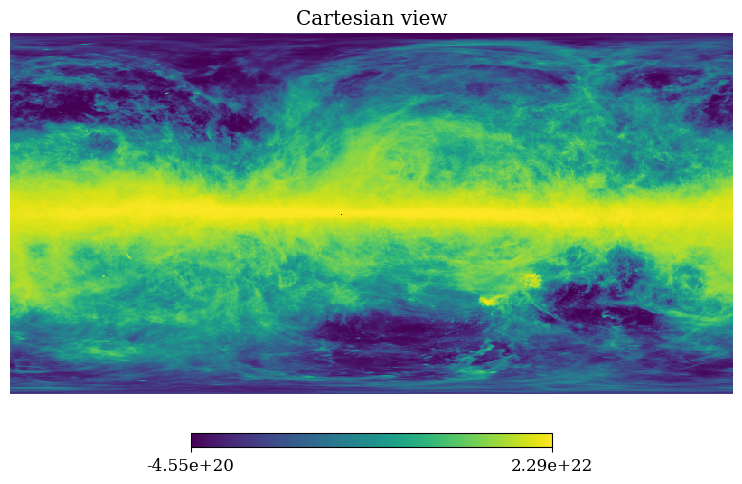

In [254]:
all_glon = [-180, 180.]
all_glat = [-90., 90.]
all_glon_cen = 0.
all_glat_cen = 0.

hi4pi_test = hp.cartview(nhi_hi4pi_map, return_projected_map=True, lonra=all_glon, latra=all_glat, norm='hist')
plt.show()

In [256]:
hi4pi_test = hi4pi_test / 1.e20

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_1922/4250387025.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar1.set_ticklabels(new_tick_labels, c='w')
/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_1922/4250387025.py:124: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(hi4pi_test), origin='lower',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


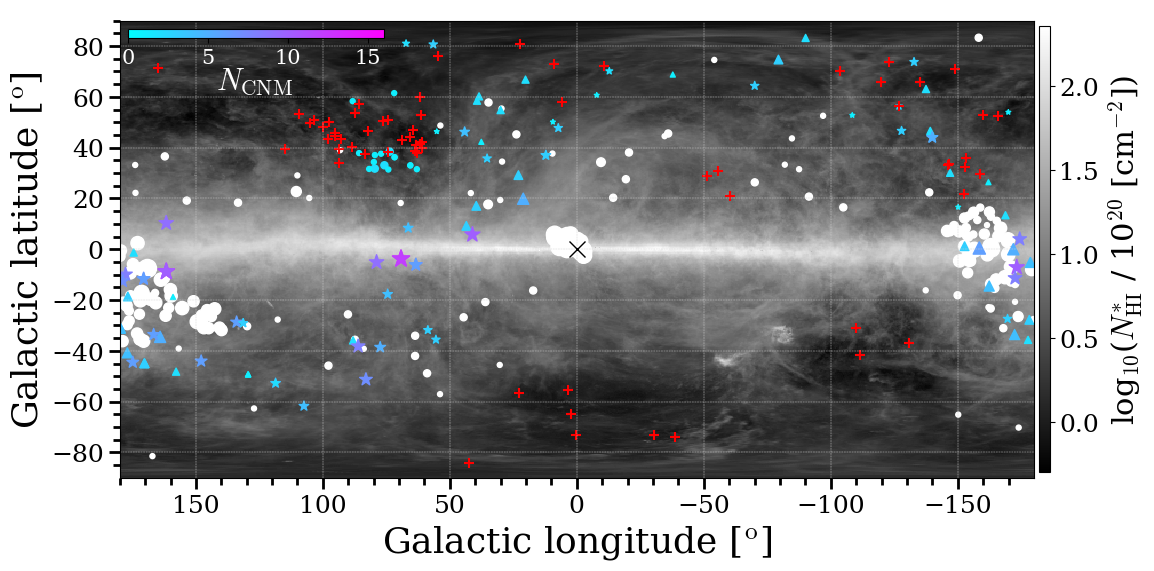

In [286]:
bighicat_ncnm = bighicat_df.ncomps.values
bighicat_ncnm_min = min(bighicat_ncnm)
bighicat_ncnm_max = max(bighicat_ncnm)


ind_z_ncnm = np.argsort(z_ncnm)
ind_z_ncnm = ind_z_ncnm[::-1]
z_ncnm_sorted = z_ncnm[ind_z_ncnm]
z_ncnm_gl = z_gl[ind_z_ncnm]
z_ncnm_gb = z_gb[ind_z_ncnm]

ind_m_ncnm = np.argsort(m_ncnm)
ind_m_ncnm = ind_m_ncnm[::-1]
m_ncnm_sorted = m_ncnm[ind_m_ncnm]
m_ncnm_gl = m_gl[ind_m_ncnm]
m_ncnm_gb = m_gb[ind_m_ncnm]


ind_sp_ncnm = np.argsort(sponge_ncnm)
ind_sp_ncnm = ind_sp_ncnm[::-1]
sp_ncnm_sorted = sponge_ncnm[ind_sp_ncnm]
sp_ncnm_gl = sponge_gl[ind_sp_ncnm]
sp_ncnm_gb = sponge_gb[ind_sp_ncnm]

ind_ms_ncnm = np.argsort(ms_ncnm)
ind_ms_ncnm = ind_ms_ncnm[::-1]
ms_ncnm_sorted = ms_ncnm[ind_ms_ncnm]
ms_ncnm_gl = ms_gl[ind_ms_ncnm]
ms_ncnm_gb = ms_gb[ind_ms_ncnm]




# Plot: 
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)

cm = 'cool'

# Display map
sct = ax.scatter(z_ncnm_gl, z_ncnm_gb,
                  zorder=1, s=z_ncnm_sorted*13,
                  c='white', marker='o', cmap=cm,
                  vmin=bighicat_ncnm_min, vmax=bighicat_ncnm_max,
                  label='')


sct = ax.scatter(m_ncnm_gl, m_ncnm_gb,
                  zorder=1, s=m_ncnm_sorted*13,
                  c=m_ncnm_sorted, marker='o', cmap=cm,
                  vmin=bighicat_ncnm_min, vmax=bighicat_ncnm_max,
                  label='')


ax.scatter(ms_ncnm_gl, ms_ncnm_gb,
                  zorder=1, s=ms_ncnm_sorted*13,
                  c=ms_ncnm_sorted, marker='^', cmap=cm,
                  vmin=bighicat_ncnm_min, vmax=bighicat_ncnm_max,
                  label='')


sct = ax.scatter(sp_ncnm_gl, sp_ncnm_gb,
                  zorder=1, s=sp_ncnm_sorted*13,
                  c=sp_ncnm_sorted, marker='*', cmap=cm,
                  vmin=bighicat_ncnm_min, vmax=bighicat_ncnm_max,
                  label='')

ax.plot(0,0, c='k', marker='x', markersize=12)

# Small cbar
axins1 = inset_axes(ax,
                width="28%",
                height="2%",
                loc="upper left",
                )
axins1.xaxis.set_ticks_position("bottom")
cbar1 = fig.colorbar(sct,
                cax=axins1,
                orientation='horizontal',
                fraction=0.,
                pad=0.1, aspect=5)
cbar1.ax.set_ylabel('$N_\mathrm{CNM}$', rotation=0, labelpad=0., fontsize=25, c='k')
cbar1.ax.tick_params(labelsize=15)
new_tick_labels = ['0', '5', '10', '15']
cbar1.set_ticklabels(new_tick_labels, c='w')


ax.scatter(bighicat_non_abs_df.lon.values,
           bighicat_non_abs_df.lat.values,
           marker='+', c='r', s=60,
           label='')





im = ax.imshow(np.log10(hi4pi_test), origin='lower',
               extent=(all_glon[1], all_glon[0], all_glat[0], all_glat[1]),
               cmap='gray', 
               interpolation='none')

ax.text(142, 63, r'$N_\mathrm{CNM}$', c='w', fontsize=22)


# Add axes labels
ax.set_xlabel(r"Galactic longitude [$^\mathrm{o}$]", fontsize=26)
ax.set_ylabel(r"Galactic latitude [$^\mathrm{o}$]", fontsize=26)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.012, pad=0.005, aspect=40)
cbar.ax.set_ylabel(r'log$_{10}$($N^{*}_\mathrm{HI}$ / 10$^{20}$ [cm$^{-2}$])', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=18)


ax.grid(True, linestyle='--', linewidth=0.35, color='lightgray', zorder=-10)


# bighicat_locs.png
plt.legend(loc='lower right', fancybox=False, framealpha=0.0, labelcolor='w', fontsize=16)
plt.show()